In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
tf.__version__

'2.4.0'

## Load Data

In [3]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

In [4]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [52]:
BATCH_SIZE = 256
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 16

END_TOKEN = 0
MAX_TIME = 1024

## Create original SeqGan

In [53]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')


def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=11):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
    embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(hidden_dim, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)

    logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
    
    generator = Model(
        inputs=i_et,
        outputs=logits)
        
    return generator

In [54]:
# # Modified from: https://gist.github.com/iskandr/a874e4cf358697037d14a17020304535
# def highway_layers(value, n_layers, activation="tanh", gate_bias=-3):
#     dim = K.int_shape(value)[-1]
#     gate_bias_initializer = tf.keras.initializers.Constant(gate_bias)
#     for i in range(n_layers):     
#         gate = Dense(units=dim, bias_initializer=gate_bias_initializer, activation='sigmoid')(value)
#         negated_gate = Lambda(
#             lambda x: 1.0 - x,
#             output_shape=(dim,))(gate)
#         transformed = Dense(units=dim, activation=activation)(value)
#         transformed_gated = Multiply()([gate, transformed])
#         identity_gated = Multiply()([negated_gate, value])
#         value = Add()([transformed_gated, identity_gated])
#     return value


# def build_D(T, event_vocab_dim, emb_dim, num_filters=100, kernel_size=4, dropout_rate=0.25):
#     # Highway network
#     i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type

#     mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
#     masked_et = mask_layer(i_et)
    
#     embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
#     embed0 = tf.squeeze(embed0, axis=2)

#     conv1 = Conv1D(
#         filters=num_filters,
#         kernel_size=kernel_size,
#         strides=1,
#         padding="valid",
#         activation='relu',
#         use_bias=True,
#         kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#         bias_initializer=tf.keras.initializers.Constant(value=0.1))(embed0)
    
#     pooled = MaxPooling1D(pool_size=T-kernel_size+1, strides=1)(conv1)
    
#     highwayed = highway_layers(pooled, n_layers=1, activation="relu", gate_bias=0)

#     dropped = Dropout(rate=dropout_rate)(highwayed)
    
#     prob = Dense(1, 
#                  activation='sigmoid',
#                  name='final',
#                  kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#                  bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)

#     discriminator = Model(
#         inputs=i_et,
#         outputs=prob)

#     return discriminator

In [55]:
def build_D_2(T, event_vocab_dim, emb_dim, dropout_rate=0.25):    
    # normal LSTM
    i_et = Input(batch_shape=(BATCH_SIZE, T, 1), name='event_type')  # input of discrete feature event type
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
    embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(HIDDEN_DIM, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)
              
    dropped = Dropout(rate=dropout_rate)(hm)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)  

    discriminator = Model(
        inputs=i_et,
        outputs=prob)

    return discriminator

## Test initial G and D

In [56]:
G = build_G(batch_size=BATCH_SIZE, event_vocab_dim=11, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM)

In [ ]:
seq_batch_1 = tf.cast(tf.random.uniform([BATCH_SIZE, T-1, 1], maxval=10, dtype=tf.int32)+1, tf.float32)
# seq_batch_1

In [ ]:
G(seq_batch_1)

In [ ]:
D = build_D(T=20, event_vocab_dim=11, emb_dim=32, num_filters=100, kernel_size=4, dropout_rate=0.25)

In [ ]:
D(seq_batch_1)

## Pre-Training of original SeqGAn

In [57]:
def pretrain_discriminator(event_type_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator(event_type_batch)

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape

    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        ce_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            target_et = event_type_batch[:, i + 1, :]

            token_logits = generator(curr_state_et)

            ce_losses = tf.keras.losses.sparse_categorical_crossentropy(target_et, token_logits, from_logits=True)
            ce_loss = tf.reduce_mean(ce_losses)
            ce_loss_list.append(ce_loss)

        generator_loss = tf.reduce_mean(ce_loss_list)

    if verbose:
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [76]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset(pos_event_type_seqs,
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [77]:
pretrain_gen_ce_loss_history = []
pretrain_gen_metrics_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [78]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 100

for event_type_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    gen_ce_loss =  pretrain_generator(event_type_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_ce_loss_history.append(gen_ce_loss.numpy())

  1%|          | 1/100 [00:00<00:32,  3.07it/s]

Training Step: 1
train loss:1.814963162693529
Training Step: 2


  2%|▏         | 2/100 [00:00<00:22,  4.44it/s]

train loss:1.8118319031776977
Training Step: 3
train loss:1.8088472605971844


  4%|▍         | 4/100 [00:00<00:17,  5.52it/s]

Training Step: 4
train loss:1.8066738570732348
Training Step: 5


  6%|▌         | 6/100 [00:01<00:15,  6.06it/s]

train loss:1.8048892065057267
Training Step: 6
train loss:1.8019095741300462
Training Step: 7


  7%|▋         | 7/100 [00:01<00:15,  5.99it/s]

train loss:1.7996755689226223
Training Step: 8
train loss:1.7983789539867243


  9%|▉         | 9/100 [00:01<00:14,  6.22it/s]

Training Step: 9
train loss:1.7965350733977143
Training Step: 10


 11%|█         | 11/100 [00:01<00:13,  6.37it/s]

train loss:1.7934872496967358
Training Step: 11
train loss:1.7907081547068677
Training Step: 12


 13%|█▎        | 13/100 [00:02<00:13,  6.44it/s]

train loss:1.788200882160298
Training Step: 13
train loss:1.787400049799959
Training Step: 14


 15%|█▌        | 15/100 [00:02<00:13,  6.37it/s]

train loss:1.7846963462681884
Training Step: 15
train loss:1.7815520175773234
Training Step: 16


 17%|█▋        | 17/100 [00:02<00:12,  6.44it/s]

train loss:1.779839075670532
Training Step: 17
train loss:1.7769530248736594
Training Step: 18


 19%|█▉        | 19/100 [00:03<00:12,  6.49it/s]

train loss:1.7748887664840307
Training Step: 19
train loss:1.7729523168556784
Training Step: 20


 21%|██        | 21/100 [00:03<00:12,  6.40it/s]

train loss:1.7694978607342247
Training Step: 21
train loss:1.768285471556851


 22%|██▏       | 22/100 [00:03<00:12,  6.40it/s]

Training Step: 22
train loss:1.7658171347654055
Training Step: 23


 24%|██▍       | 24/100 [00:03<00:11,  6.45it/s]

train loss:1.7631025657163897
Training Step: 24
train loss:1.7608708006853468
Training Step: 25


 26%|██▌       | 26/100 [00:04<00:11,  6.54it/s]

train loss:1.7571515395597885
Training Step: 26
train loss:1.7568817404749857
Training Step: 27


 28%|██▊       | 28/100 [00:04<00:11,  6.47it/s]

train loss:1.7528990735267658
Training Step: 28
train loss:1.7501532694540713
Training Step: 29


 30%|███       | 30/100 [00:04<00:10,  6.56it/s]

train loss:1.7468042424225225
Training Step: 30
train loss:1.7439299468326452
Training Step: 31


 32%|███▏      | 32/100 [00:05<00:10,  6.47it/s]

train loss:1.7423791496240035
Training Step: 32
train loss:1.7383071204491387


 33%|███▎      | 33/100 [00:05<00:10,  6.45it/s]

Training Step: 33
train loss:1.7351395701564656
Training Step: 34


 35%|███▌      | 35/100 [00:05<00:10,  6.41it/s]

train loss:1.7316827674568631
Training Step: 35
train loss:1.7284479206595322
Training Step: 36


 37%|███▋      | 37/100 [00:05<00:09,  6.50it/s]

train loss:1.7242691455060715
Training Step: 37
train loss:1.721581652185688
Training Step: 38


 38%|███▊      | 38/100 [00:06<00:09,  6.47it/s]

train loss:1.7176305336474862
Training Step: 39
train loss:1.7126042686849636


 40%|████      | 40/100 [00:06<00:09,  6.39it/s]

Training Step: 40
train loss:1.7092151193693255
Training Step: 41


 42%|████▏     | 42/100 [00:06<00:08,  6.49it/s]

train loss:1.7052419473633282
Training Step: 42
train loss:1.6992306932931864
Training Step: 43


 44%|████▍     | 44/100 [00:07<00:08,  6.48it/s]

train loss:1.6957224260915118
Training Step: 44
train loss:1.6926075036789434
Training Step: 45


 46%|████▌     | 46/100 [00:07<00:08,  6.52it/s]

train loss:1.6860402639339251
Training Step: 46
train loss:1.6814204841595024
Training Step: 47


 48%|████▊     | 48/100 [00:07<00:07,  6.52it/s]

train loss:1.6751325574945342
Training Step: 48
train loss:1.6703770576093302
Training Step: 49


 50%|█████     | 50/100 [00:07<00:07,  6.53it/s]

train loss:1.6631584699090556
Training Step: 50
train loss:1.6580319223923587
Training Step: 51


 52%|█████▏    | 52/100 [00:08<00:07,  6.55it/s]

train loss:1.6525676223819823
Training Step: 52
train loss:1.6440921589323338
Training Step: 53


 53%|█████▎    | 53/100 [00:08<00:07,  6.40it/s]

train loss:1.63722908088819
Training Step: 54
train loss:1.63043417257733


 55%|█████▌    | 55/100 [00:08<00:07,  6.38it/s]

Training Step: 55
train loss:1.6238175950989646
Training Step: 56


 56%|█████▌    | 56/100 [00:08<00:06,  6.40it/s]

train loss:1.6176764046564274
Training Step: 57
train loss:1.6129228296097093


 58%|█████▊    | 58/100 [00:09<00:06,  6.40it/s]

Training Step: 58
train loss:1.6015471551603728
Training Step: 59


 60%|██████    | 60/100 [00:09<00:06,  6.52it/s]

train loss:1.594349302895846
Training Step: 60
train loss:1.5913121561976151
Training Step: 61


 62%|██████▏   | 62/100 [00:09<00:05,  6.51it/s]

train loss:1.584078394765895
Training Step: 62
train loss:1.5779051270891844
Training Step: 63


 64%|██████▍   | 64/100 [00:10<00:05,  6.47it/s]

train loss:1.5679028807444684
Training Step: 64
train loss:1.5597927332800787
Training Step: 65


 66%|██████▌   | 66/100 [00:10<00:05,  6.43it/s]

train loss:1.5533530310658064
Training Step: 66
train loss:1.551221609611558
Training Step: 67


 68%|██████▊   | 68/100 [00:10<00:04,  6.44it/s]

train loss:1.5458509441900603
Training Step: 68
train loss:1.5384508136205781
Training Step: 69


 70%|███████   | 70/100 [00:11<00:04,  6.38it/s]

train loss:1.5325481526151081
Training Step: 70
train loss:1.5231005626292906
Training Step: 71


 72%|███████▏  | 72/100 [00:11<00:04,  6.34it/s]

train loss:1.520041065985848
Training Step: 72
train loss:1.5167605483763869
Training Step: 73


 73%|███████▎  | 73/100 [00:11<00:04,  6.35it/s]

train loss:1.5066418406872788
Training Step: 74
train loss:1.5077409317140198


 75%|███████▌  | 75/100 [00:11<00:03,  6.26it/s]

Training Step: 75
train loss:1.502049635418146
Training Step: 76


 77%|███████▋  | 77/100 [00:12<00:03,  6.37it/s]

train loss:1.4935949790423404
Training Step: 77
train loss:1.489884091141397
Training Step: 78


 79%|███████▉  | 79/100 [00:12<00:03,  6.38it/s]

train loss:1.4886848816966418
Training Step: 79
train loss:1.4797862777260566


 80%|████████  | 80/100 [00:12<00:03,  6.38it/s]

Training Step: 80
train loss:1.4778395954661843
Training Step: 81


 82%|████████▏ | 82/100 [00:12<00:02,  6.47it/s]

train loss:1.474792296366615
Training Step: 82
train loss:1.4756453516982435
Training Step: 83


 84%|████████▍ | 84/100 [00:13<00:02,  6.48it/s]

train loss:1.4708569444127702
Training Step: 84
train loss:1.4632615988499063
Training Step: 85


 85%|████████▌ | 85/100 [00:13<00:02,  6.47it/s]

train loss:1.4570411607055243
Training Step: 86
train loss:1.462550994399352


 87%|████████▋ | 87/100 [00:13<00:02,  6.38it/s]

Training Step: 87
train loss:1.4547827951903194
Training Step: 88


 88%|████████▊ | 88/100 [00:13<00:01,  6.37it/s]

train loss:1.4499436486866117
Training Step: 89
train loss:1.4492522914911807


 90%|█████████ | 90/100 [00:14<00:01,  6.36it/s]

Training Step: 90
train loss:1.4427755238999957
Training Step: 91


 92%|█████████▏| 92/100 [00:14<00:01,  6.48it/s]

train loss:1.4410467963220577
Training Step: 92
train loss:1.4433185441547614
Training Step: 93


 94%|█████████▍| 94/100 [00:14<00:00,  6.50it/s]

train loss:1.4368233076657018
Training Step: 94
train loss:1.436027623506849
Training Step: 95


 96%|█████████▌| 96/100 [00:15<00:00,  6.46it/s]

train loss:1.4335181348769204
Training Step: 96
train loss:1.43302191143246
Training Step: 97


 98%|█████████▊| 98/100 [00:15<00:00,  6.45it/s]

train loss:1.43298689183727
Training Step: 98
train loss:1.4256347922578017
Training Step: 99


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]

train loss:1.428884594365007
Training Step: 100
train loss:1.425556933955883


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


In [79]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [80]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 1)]          0         
_________________________________________________________________
masking_16 (Masking)         (256, None, 1)            0         
_________________________________________________________________
embedding_16 (Embedding)     (256, None, 1, 16)        96        
_________________________________________________________________
tf.compat.v1.squeeze_16 (TFO (256, None, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dense_1 (Dense)              (256, 6)                  102       
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
________________________________________________________

In [81]:
def rollout_from_prefix(
        G, batch_size, prefix, L=T, end_token=0, init_token=1):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = prefix
    curr_state_et = prefix[:, -1:, :]
    l_prefix = prefix.shape[1]
    
    G.reset_states()

    for _ in range(L-l_prefix):  # sequence length
        token_logits = G(curr_state_et)
        
        sampled_et = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

    return all_state_et



def generate_sequences(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    init_prefix = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    
    while N < N_gen:
        batch_state_et = rollout_from_prefix(generator, batch_size, init_prefix, T)
        batch_type_seq = batch_state_et.numpy()

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = np.concatenate([all_type_seq, batch_type_seq], axis=0)

        N += batch_size

    # convert to python list
    type_seq_list = all_type_seq[:N_gen].tolist()

    return type_seq_list

### pre-train D

In [82]:
N_fake_D = N_real_D = N_total_G // 2

In [83]:
# generate fake data by pre-trained=G to pre-train D
fake_pos_event_type_seqs = np.array(generate_sequences(N_fake_D, pretrained_generator, BATCH_SIZE, T))

In [84]:
# # generate fake data by random G to pre-train D
# random_G = build_G(
#     batch_size=BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM)

# fake_pos_event_type_seqs = np.array(generate_sequences(N_fake_D, random_G, BATCH_SIZE, T))

In [85]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]

In [86]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = np.concatenate([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_labels = np.concatenate([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset(pretrain_D_et,
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [87]:
pretrain_disc_token_loss_history = []

# pretrained_discriminator = build_D(T=T,
#                                    event_vocab_dim=EVENT_VOCAB_DIM,
#                                    emb_dim=EMB_DIM,
#                                    num_filters=100,
#                                    kernel_size=4,
#                                    dropout_rate=0.25)

pretrained_discriminator = build_D_2(T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   dropout_rate=0.25)

In [88]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
for event_type_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

  0%|          | 1/602 [00:00<02:13,  4.52it/s]

Training Step: 1
total discriminator loss:0.6953689495147142
Training Step: 2
total discriminator loss:0.6932508236321182
Training Step: 3
total discriminator loss:0.6897326771322619


  1%|          | 5/602 [00:00<00:46, 12.72it/s]

Training Step: 4
total discriminator loss:0.692038757529428
Training Step: 5
total discriminator loss:0.6905721534389196
Training Step: 6
total discriminator loss:0.6912886511148749
Training Step: 7
total discriminator loss:0.6903608857082189


  1%|▏         | 9/602 [00:00<00:38, 15.28it/s]

Training Step: 8
total discriminator loss:0.6901333056772395
Training Step: 9
total discriminator loss:0.6902949466230475
Training Step: 10
total discriminator loss:0.6889312533547896
Training Step: 11


  2%|▏         | 13/602 [00:00<00:36, 16.31it/s]

total discriminator loss:0.6895787093093317
Training Step: 12
total discriminator loss:0.6898322428443294
Training Step: 13
total discriminator loss:0.6889368237153859
Training Step: 14
total discriminator loss:0.686880697963993
Training Step: 15


  3%|▎         | 17/602 [00:01<00:34, 16.99it/s]

total discriminator loss:0.6874402334046865
Training Step: 16
total discriminator loss:0.687100682810607
Training Step: 17
total discriminator loss:0.6862342340449961
Training Step: 18
total discriminator loss:0.6868666244495674
Training Step: 19


  3%|▎         | 21/602 [00:01<00:33, 17.35it/s]

total discriminator loss:0.6865637337966973
Training Step: 20
total discriminator loss:0.6831064705193693
Training Step: 21
total discriminator loss:0.6840226900803319
Training Step: 22
total discriminator loss:0.685871254928587


  4%|▍         | 25/602 [00:01<00:33, 17.05it/s]

Training Step: 23
total discriminator loss:0.6812096465785458
Training Step: 24
total discriminator loss:0.6817616161090769
Training Step: 25
total discriminator loss:0.6817891724486426
Training Step: 26


  5%|▍         | 29/602 [00:01<00:33, 17.22it/s]

total discriminator loss:0.6783317019883927
Training Step: 27
total discriminator loss:0.6792267326916595
Training Step: 28
total discriminator loss:0.6772125448509354
Training Step: 29
total discriminator loss:0.6751053573987091
Training Step: 30


  5%|▌         | 33/602 [00:02<00:32, 17.52it/s]

total discriminator loss:0.6720906393030216
Training Step: 31
total discriminator loss:0.6703751024066775
Training Step: 32
total discriminator loss:0.6703671341350936
Training Step: 33
total discriminator loss:0.6696596196989901
Training Step: 34


  6%|▌         | 37/602 [00:02<00:32, 17.55it/s]

total discriminator loss:0.6686775812354528
Training Step: 35
total discriminator loss:0.6600665438192006
Training Step: 36
total discriminator loss:0.6549769111545757
Training Step: 37
total discriminator loss:0.6567851854638016
Training Step: 38


  7%|▋         | 41/602 [00:02<00:31, 17.59it/s]

total discriminator loss:0.6540378585031322
Training Step: 39
total discriminator loss:0.6534092110518076
Training Step: 40
total discriminator loss:0.6440477037465138
Training Step: 41
total discriminator loss:0.6288697153887015
Training Step: 42


  7%|▋         | 43/602 [00:02<00:32, 17.38it/s]

total discriminator loss:0.6461318227707613
Training Step: 43
total discriminator loss:0.6320400925904799
Training Step: 44
total discriminator loss:0.645038639872862
Training Step: 45
total discriminator loss:0.6341256256842035


  8%|▊         | 47/602 [00:02<00:32, 17.03it/s]

Training Step: 46
total discriminator loss:0.6194567054138654
Training Step: 47
total discriminator loss:0.6374030573885505
Training Step: 48
total discriminator loss:0.6190749911387927
Training Step: 49


  8%|▊         | 51/602 [00:03<00:32, 17.12it/s]

total discriminator loss:0.6234817076759079
Training Step: 50
total discriminator loss:0.6352949029129342
Training Step: 51
total discriminator loss:0.6050927234315161
Training Step: 52
total discriminator loss:0.6164085977822895


  9%|▉         | 55/602 [00:03<00:31, 17.39it/s]

Training Step: 53
total discriminator loss:0.6263526301533798
Training Step: 54
total discriminator loss:0.6159941126996291
Training Step: 55
total discriminator loss:0.6216282122545345
Training Step: 56
total discriminator loss:0.5896361241982615


 10%|▉         | 59/602 [00:03<00:31, 17.46it/s]

Training Step: 57
total discriminator loss:0.6112108639921167
Training Step: 58
total discriminator loss:0.6167116591630994
Training Step: 59
total discriminator loss:0.611961525300441
Training Step: 60
total discriminator loss:0.6123937619277567


 10%|█         | 63/602 [00:03<00:30, 17.53it/s]

Training Step: 61
total discriminator loss:0.59825991836796
Training Step: 62
total discriminator loss:0.5914853595386409
Training Step: 63
total discriminator loss:0.5912130283571337
Training Step: 64
total discriminator loss:0.5801237387241209


 11%|█         | 67/602 [00:04<00:31, 16.95it/s]

Training Step: 65
total discriminator loss:0.5818072995336911
Training Step: 66
total discriminator loss:0.5852982838631351
Training Step: 67
total discriminator loss:0.5840888141827045
Training Step: 68


 11%|█▏        | 69/602 [00:04<00:32, 16.56it/s]

total discriminator loss:0.5627098850851304
Training Step: 69
total discriminator loss:0.5838944970246739
Training Step: 70
total discriminator loss:0.5645974744405691
Training Step: 71
total discriminator loss:0.5804779342150027


 12%|█▏        | 73/602 [00:04<00:31, 16.90it/s]

Training Step: 72
total discriminator loss:0.5740340200398066
Training Step: 73
total discriminator loss:0.5666659548113093
Training Step: 74
total discriminator loss:0.568910973308457
Training Step: 75
total discriminator loss:0.5403749916173569


 13%|█▎        | 77/602 [00:04<00:30, 17.00it/s]

Training Step: 76
total discriminator loss:0.5389163833257244
Training Step: 77
total discriminator loss:0.5416758893939796
Training Step: 78
total discriminator loss:0.5350223249485253
Training Step: 79


 13%|█▎        | 81/602 [00:04<00:30, 17.28it/s]

total discriminator loss:0.5245597953715573
Training Step: 80
total discriminator loss:0.5547817569346981
Training Step: 81
total discriminator loss:0.5205270385675392
Training Step: 82
total discriminator loss:0.5688154267403491
Training Step: 83


 14%|█▍        | 85/602 [00:05<00:29, 17.43it/s]

total discriminator loss:0.5486006903575491
Training Step: 84
total discriminator loss:0.5531633700762197
Training Step: 85
total discriminator loss:0.5506247949526488
Training Step: 86
total discriminator loss:0.5741509437008421
Training Step: 87


 15%|█▍        | 89/602 [00:05<00:29, 17.39it/s]

total discriminator loss:0.5612031914339837
Training Step: 88
total discriminator loss:0.5252349887035787
Training Step: 89
total discriminator loss:0.5474098575452709
Training Step: 90
total discriminator loss:0.5255098906757041
Training Step: 91


 15%|█▌        | 93/602 [00:05<00:29, 17.48it/s]

total discriminator loss:0.5506517498077683
Training Step: 92
total discriminator loss:0.5379614350244678
Training Step: 93
total discriminator loss:0.5382234620765369
Training Step: 94
total discriminator loss:0.5242383642762232


 16%|█▌        | 97/602 [00:05<00:29, 17.24it/s]

Training Step: 95
total discriminator loss:0.5383508434747367
Training Step: 96
total discriminator loss:0.554113001513984
Training Step: 97
total discriminator loss:0.53277783861102
Training Step: 98


 17%|█▋        | 101/602 [00:06<00:28, 17.37it/s]

total discriminator loss:0.5561529951679862
Training Step: 99
total discriminator loss:0.5284751424176939
Training Step: 100
total discriminator loss:0.5249345838949684
Training Step: 101
total discriminator loss:0.5646680551523446
Training Step: 102


 17%|█▋        | 103/602 [00:06<00:28, 17.32it/s]

total discriminator loss:0.5505812557560764
Training Step: 103
total discriminator loss:0.5152201811621107
Training Step: 104
total discriminator loss:0.5255208194576491
Training Step: 105
total discriminator loss:0.5306611380184684


 18%|█▊        | 107/602 [00:06<00:28, 17.21it/s]

Training Step: 106
total discriminator loss:0.5355898650606536
Training Step: 107
total discriminator loss:0.5038340999133892
Training Step: 108
total discriminator loss:0.5483370109720574
Training Step: 109


 18%|█▊        | 111/602 [00:06<00:28, 17.27it/s]

total discriminator loss:0.55768474907762
Training Step: 110
total discriminator loss:0.4902199073129235
Training Step: 111
total discriminator loss:0.5044708682960386
Training Step: 112
total discriminator loss:0.5309322734589175
Training Step: 113


 19%|█▉        | 115/602 [00:06<00:28, 17.10it/s]

total discriminator loss:0.5045894427164516
Training Step: 114
total discriminator loss:0.5408956323429308
Training Step: 115
total discriminator loss:0.5028368574069284
Training Step: 116
total discriminator loss:0.4966039466371497


 20%|█▉        | 119/602 [00:07<00:28, 17.04it/s]

Training Step: 117
total discriminator loss:0.5264122343068679
Training Step: 118
total discriminator loss:0.5038870347938184
Training Step: 119
total discriminator loss:0.5267282503678098
Training Step: 120


 20%|██        | 123/602 [00:07<00:28, 17.06it/s]

total discriminator loss:0.5145837159548559
Training Step: 121
total discriminator loss:0.5724298122038907
Training Step: 122
total discriminator loss:0.5150146951648013
Training Step: 123
total discriminator loss:0.5158737447748722


 21%|██        | 125/602 [00:07<00:27, 17.22it/s]

Training Step: 124
total discriminator loss:0.5625029137599146
Training Step: 125
total discriminator loss:0.5226819325056743
Training Step: 126
total discriminator loss:0.540815493967165
Training Step: 127
total discriminator loss:0.5148954820675211


 21%|██▏       | 129/602 [00:07<00:27, 17.04it/s]

Training Step: 128
total discriminator loss:0.5459694084182019
Training Step: 129
total discriminator loss:0.512011639754205
Training Step: 130
total discriminator loss:0.5266319495605472
Training Step: 131


 22%|██▏       | 133/602 [00:07<00:27, 16.80it/s]

total discriminator loss:0.5092004976372743
Training Step: 132
total discriminator loss:0.512660115684525
Training Step: 133
total discriminator loss:0.5074601663241558
Training Step: 134
total discriminator loss:0.5107508146041502


 23%|██▎       | 137/602 [00:08<00:27, 17.01it/s]

Training Step: 135
total discriminator loss:0.5446660335546983
Training Step: 136
total discriminator loss:0.5162149146768962
Training Step: 137
total discriminator loss:0.5479946845751691
Training Step: 138


 23%|██▎       | 139/602 [00:08<00:26, 17.18it/s]

total discriminator loss:0.5496741820118538
Training Step: 139
total discriminator loss:0.5228101189975701
Training Step: 140
total discriminator loss:0.5045703324415323
Training Step: 141
total discriminator loss:0.5049324481789509


 24%|██▍       | 143/602 [00:08<00:26, 17.10it/s]

Training Step: 142
total discriminator loss:0.5173513798687981
Training Step: 143
total discriminator loss:0.48705099965813703
Training Step: 144
total discriminator loss:0.49120959049066215
Training Step: 145
total discriminator loss:0.5238123891309692


 24%|██▍       | 147/602 [00:08<00:26, 17.28it/s]

Training Step: 146
total discriminator loss:0.5129566669866066
Training Step: 147
total discriminator loss:0.4765982457491853
Training Step: 148
total discriminator loss:0.5125255468077833
Training Step: 149


 25%|██▌       | 151/602 [00:08<00:26, 16.97it/s]

total discriminator loss:0.5113620717523595
Training Step: 150
total discriminator loss:0.4677851988051086
Training Step: 151
total discriminator loss:0.5208879036326555
Training Step: 152
total discriminator loss:0.49779664521958944


 26%|██▌       | 155/602 [00:09<00:25, 17.22it/s]

Training Step: 153
total discriminator loss:0.511911109006382
Training Step: 154
total discriminator loss:0.5222140887436479
Training Step: 155
total discriminator loss:0.529851830928302
Training Step: 156
total discriminator loss:0.5287036287207216


 26%|██▋       | 159/602 [00:09<00:25, 17.28it/s]

Training Step: 157
total discriminator loss:0.47689249192403743
Training Step: 158
total discriminator loss:0.5058831766063044
Training Step: 159
total discriminator loss:0.4869790287162735
Training Step: 160


 27%|██▋       | 163/602 [00:09<00:25, 17.43it/s]

total discriminator loss:0.533452020152476
Training Step: 161
total discriminator loss:0.5132561740272982
Training Step: 162
total discriminator loss:0.4830159358099834
Training Step: 163
total discriminator loss:0.5131728218491336
Training Step: 164


 27%|██▋       | 165/602 [00:09<00:25, 17.18it/s]

total discriminator loss:0.526532428331624
Training Step: 165
total discriminator loss:0.4809760217253186
Training Step: 166
total discriminator loss:0.5027210229931185
Training Step: 167
total discriminator loss:0.5006232601559791


 28%|██▊       | 169/602 [00:09<00:25, 16.77it/s]

Training Step: 168
total discriminator loss:0.5268189233824637
Training Step: 169
total discriminator loss:0.508652029371238
Training Step: 170
total discriminator loss:0.4878757758028601
Training Step: 171


 29%|██▊       | 173/602 [00:10<00:25, 16.90it/s]

total discriminator loss:0.47550957983101805
Training Step: 172
total discriminator loss:0.49611263709227027
Training Step: 173
total discriminator loss:0.479485046368353
Training Step: 174
total discriminator loss:0.48799112751218465
Training Step: 175


 29%|██▉       | 177/602 [00:10<00:24, 17.11it/s]

total discriminator loss:0.48434872548587043
Training Step: 176
total discriminator loss:0.4894432647260222
Training Step: 177
total discriminator loss:0.4928171422969893
Training Step: 178
total discriminator loss:0.4964481667172112
Training Step: 179


 30%|███       | 181/602 [00:10<00:24, 17.30it/s]

total discriminator loss:0.48536809375605794
Training Step: 180
total discriminator loss:0.4796205552792743
Training Step: 181
total discriminator loss:0.47441152113559554
Training Step: 182
total discriminator loss:0.46733628865510723
Training Step: 183


 31%|███       | 185/602 [00:10<00:24, 17.16it/s]

total discriminator loss:0.4920387316479758
Training Step: 184
total discriminator loss:0.4623266656431129
Training Step: 185
total discriminator loss:0.4828242938148706
Training Step: 186
total discriminator loss:0.47557289576231637
Training Step: 187


 31%|███▏      | 189/602 [00:11<00:24, 17.14it/s]

total discriminator loss:0.46333756469532805
Training Step: 188
total discriminator loss:0.46925127850056714
Training Step: 189
total discriminator loss:0.4860754803493901
Training Step: 190
total discriminator loss:0.47062859280738756
Training Step: 191


 32%|███▏      | 193/602 [00:11<00:23, 17.26it/s]

total discriminator loss:0.48488529114191947
Training Step: 192
total discriminator loss:0.46522361515410277
Training Step: 193
total discriminator loss:0.47544140422266623
Training Step: 194
total discriminator loss:0.5086890968899515
Training Step: 195


 33%|███▎      | 197/602 [00:11<00:23, 17.40it/s]

total discriminator loss:0.4863852906650316
Training Step: 196
total discriminator loss:0.5120487315117273
Training Step: 197
total discriminator loss:0.4363105375977001
Training Step: 198
total discriminator loss:0.4467227045543556
Training Step: 199


 33%|███▎      | 201/602 [00:11<00:23, 17.16it/s]

total discriminator loss:0.45019432038105767
Training Step: 200
total discriminator loss:0.4425502138542414
Training Step: 201
total discriminator loss:0.44979921817824076
Training Step: 202
total discriminator loss:0.4344238432545998


 34%|███▍      | 205/602 [00:12<00:23, 16.73it/s]

Training Step: 203
total discriminator loss:0.44884633816477326
Training Step: 204
total discriminator loss:0.42635246841063523
Training Step: 205
total discriminator loss:0.45073092242795054
Training Step: 206


 35%|███▍      | 209/602 [00:12<00:22, 17.11it/s]

total discriminator loss:0.4493915131391877
Training Step: 207
total discriminator loss:0.439631035311324
Training Step: 208
total discriminator loss:0.426676217735275
Training Step: 209
total discriminator loss:0.43111123806162566
Training Step: 210


 35%|███▌      | 211/602 [00:12<00:22, 17.14it/s]

total discriminator loss:0.4348829254903661
Training Step: 211
total discriminator loss:0.4468546969045576
Training Step: 212
total discriminator loss:0.4587370547222883
Training Step: 213
total discriminator loss:0.45101087872753215


 36%|███▌      | 215/602 [00:12<00:23, 16.60it/s]

Training Step: 214
total discriminator loss:0.43734049824739785
Training Step: 215
total discriminator loss:0.4329015537448666
Training Step: 216
total discriminator loss:0.4422381710794428
Training Step: 217


 36%|███▋      | 219/602 [00:12<00:22, 16.79it/s]

total discriminator loss:0.4725683619644289
Training Step: 218
total discriminator loss:0.43150997697619076
Training Step: 219
total discriminator loss:0.39381440053130257
Training Step: 220
total discriminator loss:0.43194703149719227


 37%|███▋      | 223/602 [00:13<00:22, 16.67it/s]

Training Step: 221
total discriminator loss:0.40690669336011437
Training Step: 222
total discriminator loss:0.4441369041745623
Training Step: 223
total discriminator loss:0.4259978320777492
Training Step: 224


 38%|███▊      | 227/602 [00:13<00:22, 16.99it/s]

total discriminator loss:0.4095621971098317
Training Step: 225
total discriminator loss:0.43369020622778376
Training Step: 226
total discriminator loss:0.40423519432307997
Training Step: 227
total discriminator loss:0.41992671882545707
Training Step: 228


 38%|███▊      | 231/602 [00:13<00:21, 17.20it/s]

total discriminator loss:0.4305050862651132
Training Step: 229
total discriminator loss:0.41876813181930794
Training Step: 230
total discriminator loss:0.4238011929934641
Training Step: 231
total discriminator loss:0.39121135422525477
Training Step: 232


 39%|███▊      | 233/602 [00:13<00:21, 17.03it/s]

total discriminator loss:0.47850633232517903
Training Step: 233
total discriminator loss:0.40310388825728727
Training Step: 234
total discriminator loss:0.45582246012297767
Training Step: 235
total discriminator loss:0.4203996561733503


 39%|███▉      | 237/602 [00:13<00:21, 17.29it/s]

Training Step: 236
total discriminator loss:0.3982923071922215
Training Step: 237
total discriminator loss:0.43169599675641424
Training Step: 238
total discriminator loss:0.39538715624464005
Training Step: 239
total discriminator loss:0.41447418851739626


 40%|████      | 241/602 [00:14<00:20, 17.38it/s]

Training Step: 240
total discriminator loss:0.44355859229428374
Training Step: 241
total discriminator loss:0.40105442947355696
Training Step: 242
total discriminator loss:0.4747760157606714
Training Step: 243
total discriminator loss:0.42304167032706885


 41%|████      | 245/602 [00:14<00:20, 17.42it/s]

Training Step: 244
total discriminator loss:0.4400674578467999
Training Step: 245
total discriminator loss:0.46268393043867434
Training Step: 246
total discriminator loss:0.40764846728114035
Training Step: 247


 41%|████▏     | 249/602 [00:14<00:20, 17.23it/s]

total discriminator loss:0.3961743875026978
Training Step: 248
total discriminator loss:0.4302456153784625
Training Step: 249
total discriminator loss:0.4328361683642127
Training Step: 250
total discriminator loss:0.3616664095619509


 42%|████▏     | 253/602 [00:14<00:20, 17.27it/s]

Training Step: 251
total discriminator loss:0.44804983996008146
Training Step: 252
total discriminator loss:0.4269775356621632
Training Step: 253
total discriminator loss:0.4317941221620297
Training Step: 254


 43%|████▎     | 257/602 [00:15<00:19, 17.39it/s]

total discriminator loss:0.4352992814627214
Training Step: 255
total discriminator loss:0.41687537211107084
Training Step: 256
total discriminator loss:0.41116836459960016
Training Step: 257
total discriminator loss:0.4257874620127519
Training Step: 258


 43%|████▎     | 261/602 [00:15<00:19, 17.43it/s]

total discriminator loss:0.3798505968740828
Training Step: 259
total discriminator loss:0.41889551275439774
Training Step: 260
total discriminator loss:0.4089669760612227
Training Step: 261
total discriminator loss:0.38234662995913304
Training Step: 262


 44%|████▍     | 265/602 [00:15<00:19, 17.41it/s]

total discriminator loss:0.43372460621567477
Training Step: 263
total discriminator loss:0.4460338261124429
Training Step: 264
total discriminator loss:0.41177965725583315
Training Step: 265
total discriminator loss:0.37301425538320365
Training Step: 266


 44%|████▍     | 267/602 [00:15<00:19, 17.17it/s]

total discriminator loss:0.4142934408273554
Training Step: 267
total discriminator loss:0.4142186639270307
Training Step: 268
total discriminator loss:0.4592699292058312
Training Step: 269
total discriminator loss:0.42237931729234457


 45%|████▌     | 271/602 [00:15<00:19, 17.03it/s]

Training Step: 270
total discriminator loss:0.44627618271681035
Training Step: 271
total discriminator loss:0.39114194141180436
Training Step: 272
total discriminator loss:0.4044462733095843
Training Step: 273


 46%|████▌     | 275/602 [00:16<00:18, 17.31it/s]

total discriminator loss:0.3506283641632497
Training Step: 274
total discriminator loss:0.4104715570792241
Training Step: 275
total discriminator loss:0.3995407726987201
Training Step: 276
total discriminator loss:0.40602147122373156
Training Step: 277


 46%|████▋     | 279/602 [00:16<00:18, 17.19it/s]

total discriminator loss:0.37401635059101646
Training Step: 278
total discriminator loss:0.4345922692926321
Training Step: 279
total discriminator loss:0.4508922708784522
Training Step: 280


 47%|████▋     | 283/602 [00:16<00:18, 17.36it/s]

total discriminator loss:0.37744423618872336
Training Step: 281
total discriminator loss:0.39060252287297115
Training Step: 282
total discriminator loss:0.40053366028793147
Training Step: 283
total discriminator loss:0.39983368281910714
Training Step: 284


 48%|████▊     | 287/602 [00:16<00:18, 17.38it/s]

total discriminator loss:0.3841131238426743
Training Step: 285
total discriminator loss:0.4056363173646698
Training Step: 286
total discriminator loss:0.3912009705109575
Training Step: 287
total discriminator loss:0.4238524371946816
Training Step: 288


 48%|████▊     | 291/602 [00:17<00:17, 17.40it/s]

total discriminator loss:0.4402726672116104
Training Step: 289
total discriminator loss:0.3671068092995029
Training Step: 290
total discriminator loss:0.4409526050606952
Training Step: 291
total discriminator loss:0.3928425125217547
Training Step: 292


 49%|████▊     | 293/602 [00:17<00:17, 17.45it/s]

total discriminator loss:0.4213169969166761
Training Step: 293
total discriminator loss:0.3980953917491487
Training Step: 294
total discriminator loss:0.4058749714906198
Training Step: 295
total discriminator loss:0.3903732486352276


 49%|████▉     | 297/602 [00:17<00:18, 16.77it/s]

Training Step: 296
total discriminator loss:0.4095498419236402
Training Step: 297
total discriminator loss:0.4253600001477913
Training Step: 298
total discriminator loss:0.415721796999598
Training Step: 299


 50%|█████     | 301/602 [00:17<00:17, 17.14it/s]

total discriminator loss:0.44228776693885596
Training Step: 300
total discriminator loss:0.40457181111327034
Training Step: 301
total discriminator loss:0.371568469736119
Training Step: 302
total discriminator loss:0.41553510999521903
Training Step: 303


 51%|█████     | 305/602 [00:17<00:17, 16.65it/s]

total discriminator loss:0.41943460262466914
Training Step: 304
total discriminator loss:0.3709111965879992
Training Step: 305
total discriminator loss:0.40832030544952813
Training Step: 306
total discriminator loss:0.38846546469679


 51%|█████▏    | 309/602 [00:18<00:17, 16.51it/s]

Training Step: 307
total discriminator loss:0.419505130976373
Training Step: 308
total discriminator loss:0.3989585742672368
Training Step: 309
total discriminator loss:0.3993400982870607
Training Step: 310


 52%|█████▏    | 313/602 [00:18<00:16, 17.01it/s]

total discriminator loss:0.45872278737703953
Training Step: 311
total discriminator loss:0.4096769786217258
Training Step: 312
total discriminator loss:0.45922428997094866
Training Step: 313
total discriminator loss:0.3621608275911698
Training Step: 314


 52%|█████▏    | 315/602 [00:18<00:16, 17.19it/s]

total discriminator loss:0.4481124643082617
Training Step: 315
total discriminator loss:0.4528070317515182
Training Step: 316
total discriminator loss:0.39919671669699575
Training Step: 317
total discriminator loss:0.4025330877178108


 53%|█████▎    | 319/602 [00:18<00:16, 17.07it/s]

Training Step: 318
total discriminator loss:0.40943528725629746
Training Step: 319
total discriminator loss:0.36818727503220994
Training Step: 320
total discriminator loss:0.3831714921385193
Training Step: 321


 54%|█████▎    | 323/602 [00:18<00:16, 17.27it/s]

total discriminator loss:0.43838971267474286
Training Step: 322
total discriminator loss:0.3748115720910873
Training Step: 323
total discriminator loss:0.41346600885773666
Training Step: 324
total discriminator loss:0.40359009983634775
Training Step: 325


 54%|█████▍    | 327/602 [00:19<00:16, 17.03it/s]

total discriminator loss:0.3890944135018288
Training Step: 326
total discriminator loss:0.4141565048504461
Training Step: 327
total discriminator loss:0.3963048980993078
Training Step: 328
total discriminator loss:0.45427681629498307


 55%|█████▍    | 331/602 [00:19<00:15, 17.09it/s]

Training Step: 329
total discriminator loss:0.3405610461994778
Training Step: 330
total discriminator loss:0.37461335779720395
Training Step: 331
total discriminator loss:0.36060246536654594
Training Step: 332


 55%|█████▌    | 333/602 [00:19<00:15, 16.93it/s]

total discriminator loss:0.4318521267005415
Training Step: 333
total discriminator loss:0.36734770025390107
Training Step: 334
total discriminator loss:0.38589663891578363
Training Step: 335
total discriminator loss:0.3600410069817119


 56%|█████▌    | 337/602 [00:19<00:15, 16.60it/s]

Training Step: 336
total discriminator loss:0.43795565984706475
Training Step: 337
total discriminator loss:0.40364999564720583
Training Step: 338
total discriminator loss:0.4125109648799468
Training Step: 339


 57%|█████▋    | 341/602 [00:20<00:15, 16.95it/s]

total discriminator loss:0.35889663633671665
Training Step: 340
total discriminator loss:0.35914126015237136
Training Step: 341
total discriminator loss:0.4389313797918488
Training Step: 342
total discriminator loss:0.3801457946014088
Training Step: 343


 57%|█████▋    | 345/602 [00:20<00:14, 17.17it/s]

total discriminator loss:0.3792710015396177
Training Step: 344
total discriminator loss:0.3969497566812751
Training Step: 345
total discriminator loss:0.38140949282031356
Training Step: 346
total discriminator loss:0.45651771445052863
Training Step: 347


 58%|█████▊    | 349/602 [00:20<00:15, 16.74it/s]

total discriminator loss:0.4194980002761918
Training Step: 348
total discriminator loss:0.3957518243463567
Training Step: 349
total discriminator loss:0.36939716438015646
Training Step: 350
total discriminator loss:0.41381869991218445


 59%|█████▊    | 353/602 [00:20<00:14, 17.06it/s]

Training Step: 351
total discriminator loss:0.4160903279367767
Training Step: 352
total discriminator loss:0.38957367390493575
Training Step: 353
total discriminator loss:0.39891697955058936
Training Step: 354


 59%|█████▉    | 355/602 [00:20<00:14, 17.19it/s]

total discriminator loss:0.3917698589646962
Training Step: 355
total discriminator loss:0.40171943374103525
Training Step: 356
total discriminator loss:0.4020238801954928
Training Step: 357
total discriminator loss:0.4002436365997027


 60%|█████▉    | 359/602 [00:21<00:14, 17.15it/s]

Training Step: 358
total discriminator loss:0.39031245543355464
Training Step: 359
total discriminator loss:0.3856893923735696
Training Step: 360
total discriminator loss:0.39305721470653454
Training Step: 361
total discriminator loss:0.3631916567899808


 60%|██████    | 363/602 [00:21<00:13, 17.11it/s]

Training Step: 362
total discriminator loss:0.3845589890290596
Training Step: 363
total discriminator loss:0.42190509062517834
Training Step: 364
total discriminator loss:0.41702878368702034
Training Step: 365


 61%|██████    | 367/602 [00:21<00:13, 16.80it/s]

total discriminator loss:0.4156140093163787
Training Step: 366
total discriminator loss:0.3617405109692484
Training Step: 367
total discriminator loss:0.3905041142917631
Training Step: 368
total discriminator loss:0.40938551714825144


 62%|██████▏   | 371/602 [00:21<00:13, 17.11it/s]

Training Step: 369
total discriminator loss:0.4190754581689926
Training Step: 370
total discriminator loss:0.3786748399738541
Training Step: 371
total discriminator loss:0.3829281601458437
Training Step: 372


 62%|██████▏   | 373/602 [00:21<00:13, 16.93it/s]

total discriminator loss:0.3753000669484395
Training Step: 373
total discriminator loss:0.358740909442013
Training Step: 374
total discriminator loss:0.3783690844690698
Training Step: 375
total discriminator loss:0.36515395375491333


 63%|██████▎   | 377/602 [00:22<00:13, 17.10it/s]

Training Step: 376
total discriminator loss:0.39721940122766564
Training Step: 377
total discriminator loss:0.3917299867261959
Training Step: 378
total discriminator loss:0.3932753711786816
Training Step: 379


 63%|██████▎   | 381/602 [00:22<00:12, 17.20it/s]

total discriminator loss:0.3668053732787169
Training Step: 380
total discriminator loss:0.396121354163988
Training Step: 381
total discriminator loss:0.3551101527054209
Training Step: 382
total discriminator loss:0.3511839583672307
Training Step: 383


 64%|██████▍   | 385/602 [00:22<00:12, 17.19it/s]

total discriminator loss:0.3571898450312209
Training Step: 384
total discriminator loss:0.36659314970075046
Training Step: 385
total discriminator loss:0.3636638022672978
Training Step: 386
total discriminator loss:0.3635000609018767


 65%|██████▍   | 389/602 [00:22<00:12, 16.92it/s]

Training Step: 387
total discriminator loss:0.3663662778532899
Training Step: 388
total discriminator loss:0.3790033996579516
Training Step: 389
total discriminator loss:0.34364235007103605
Training Step: 390


 65%|██████▌   | 393/602 [00:23<00:12, 17.20it/s]

total discriminator loss:0.396841987842181
Training Step: 391
total discriminator loss:0.3450041102403998
Training Step: 392
total discriminator loss:0.4192630058368762
Training Step: 393
total discriminator loss:0.37575990377912877
Training Step: 394


 66%|██████▌   | 397/602 [00:23<00:11, 17.29it/s]

total discriminator loss:0.36134463839525344
Training Step: 395
total discriminator loss:0.45192781556905426
Training Step: 396
total discriminator loss:0.3802665542977218
Training Step: 397
total discriminator loss:0.447538049676922
Training Step: 398


 66%|██████▋   | 399/602 [00:23<00:11, 17.04it/s]

total discriminator loss:0.3960667159574722
Training Step: 399
total discriminator loss:0.3834922497944498
Training Step: 400
total discriminator loss:0.37345434884458373
Training Step: 401
total discriminator loss:0.4172616992714108


 67%|██████▋   | 403/602 [00:23<00:11, 16.96it/s]

Training Step: 402
total discriminator loss:0.41146130657502933
Training Step: 403
total discriminator loss:0.36124600709138566
Training Step: 404
total discriminator loss:0.37999880831013266
Training Step: 405


 68%|██████▊   | 407/602 [00:23<00:11, 17.11it/s]

total discriminator loss:0.37134676621476037
Training Step: 406
total discriminator loss:0.4013594247378111
Training Step: 407
total discriminator loss:0.3980604086089762
Training Step: 408
total discriminator loss:0.36379912828095073


 68%|██████▊   | 411/602 [00:24<00:11, 17.27it/s]

Training Step: 409
total discriminator loss:0.3956130530169913
Training Step: 410
total discriminator loss:0.39034932515125503
Training Step: 411
total discriminator loss:0.4307511259420602
Training Step: 412
total discriminator loss:0.4100869459652434


 69%|██████▉   | 415/602 [00:24<00:10, 17.37it/s]

Training Step: 413
total discriminator loss:0.37964814232825617
Training Step: 414
total discriminator loss:0.3702952495065689
Training Step: 415
total discriminator loss:0.3709680072928252
Training Step: 416
total discriminator loss:0.3407136737570696


 70%|██████▉   | 419/602 [00:24<00:10, 17.09it/s]

Training Step: 417
total discriminator loss:0.38722141195191845
Training Step: 418
total discriminator loss:0.3618115857481821
Training Step: 419
total discriminator loss:0.4375433046306873
Training Step: 420


 70%|███████   | 423/602 [00:24<00:10, 17.09it/s]

total discriminator loss:0.375307373128682
Training Step: 421
total discriminator loss:0.4138863870636035
Training Step: 422
total discriminator loss:0.3508323856404652
Training Step: 423
total discriminator loss:0.3681219886035713


 71%|███████   | 425/602 [00:24<00:10, 17.18it/s]

Training Step: 424
total discriminator loss:0.3867322136596456
Training Step: 425
total discriminator loss:0.3668032219423114
Training Step: 426
total discriminator loss:0.3464091415190763
Training Step: 427


 71%|███████▏  | 429/602 [00:25<00:10, 17.24it/s]

total discriminator loss:0.3819453625681981
Training Step: 428
total discriminator loss:0.3697777214462218
Training Step: 429
total discriminator loss:0.3810385709058404
Training Step: 430
total discriminator loss:0.3647288795030883
Training Step: 431


 72%|███████▏  | 433/602 [00:25<00:09, 17.12it/s]

total discriminator loss:0.4090439488018266
Training Step: 432
total discriminator loss:0.38889953120721854
Training Step: 433
total discriminator loss:0.41912074114734676
Training Step: 434
total discriminator loss:0.3622293973070779
Training Step: 435


 73%|███████▎  | 437/602 [00:25<00:09, 17.31it/s]

total discriminator loss:0.3907492888992068
Training Step: 436
total discriminator loss:0.3748233134662464
Training Step: 437
total discriminator loss:0.3981705788019508
Training Step: 438
total discriminator loss:0.3913403399787902
Training Step: 439


 73%|███████▎  | 441/602 [00:25<00:09, 17.43it/s]

total discriminator loss:0.41725412892693764
Training Step: 440
total discriminator loss:0.35367921145743375
Training Step: 441
total discriminator loss:0.42784552564972794
Training Step: 442
total discriminator loss:0.37354005069781915
Training Step: 443


 74%|███████▍  | 445/602 [00:26<00:09, 17.30it/s]

total discriminator loss:0.39980322098974463
Training Step: 444
total discriminator loss:0.34738078449251597
Training Step: 445
total discriminator loss:0.3904399009024325
Training Step: 446
total discriminator loss:0.3900845736156086


 75%|███████▍  | 449/602 [00:26<00:08, 17.01it/s]

Training Step: 447
total discriminator loss:0.4051519349499815
Training Step: 448
total discriminator loss:0.37928205420758326
Training Step: 449
total discriminator loss:0.39037935122862377
Training Step: 450


 75%|███████▌  | 453/602 [00:26<00:08, 17.22it/s]

total discriminator loss:0.37969520558713477
Training Step: 451
total discriminator loss:0.34706807704072873
Training Step: 452
total discriminator loss:0.3776884804223415
Training Step: 453
total discriminator loss:0.4014877668220275
Training Step: 454


 76%|███████▌  | 457/602 [00:26<00:08, 17.43it/s]

total discriminator loss:0.3668371913032561
Training Step: 455
total discriminator loss:0.41560940840694316
Training Step: 456
total discriminator loss:0.3724610946158077
Training Step: 457
total discriminator loss:0.3594062130965664
Training Step: 458


 76%|███████▌  | 459/602 [00:26<00:08, 17.02it/s]

total discriminator loss:0.3692597525817428
Training Step: 459
total discriminator loss:0.3814372416525776
Training Step: 460
total discriminator loss:0.43715509026975796
Training Step: 461
total discriminator loss:0.38116467381916863


 77%|███████▋  | 463/602 [00:27<00:08, 17.08it/s]

Training Step: 462
total discriminator loss:0.41061900355409553
Training Step: 463
total discriminator loss:0.43866060221454234
Training Step: 464
total discriminator loss:0.34826784184859416
Training Step: 465


 78%|███████▊  | 467/602 [00:27<00:07, 17.20it/s]

total discriminator loss:0.4411640574244602
Training Step: 466
total discriminator loss:0.38754000999046845
Training Step: 467
total discriminator loss:0.35436941941188477
Training Step: 468
total discriminator loss:0.4104413903450228
Training Step: 469


 78%|███████▊  | 471/602 [00:27<00:07, 17.16it/s]

total discriminator loss:0.39807259538417505
Training Step: 470
total discriminator loss:0.3985228926775877
Training Step: 471
total discriminator loss:0.3968153914692104
Training Step: 472
total discriminator loss:0.4289325590984076
Training Step: 473


 79%|███████▉  | 475/602 [00:27<00:07, 17.13it/s]

total discriminator loss:0.36801506960185415
Training Step: 474
total discriminator loss:0.3781500814423976
Training Step: 475
total discriminator loss:0.38492206420889
Training Step: 476
total discriminator loss:0.36708174983677905
Training Step: 477


 80%|███████▉  | 479/602 [00:28<00:07, 17.33it/s]

total discriminator loss:0.40188103228264915
Training Step: 478
total discriminator loss:0.38281768655872084
Training Step: 479
total discriminator loss:0.4302813610215644
Training Step: 480
total discriminator loss:0.34805664663838176


 80%|████████  | 483/602 [00:28<00:06, 17.12it/s]

Training Step: 481
total discriminator loss:0.3512486883546494
Training Step: 482
total discriminator loss:0.341983822915078
Training Step: 483
total discriminator loss:0.41682139205664076
Training Step: 484


 81%|████████  | 485/602 [00:28<00:06, 16.94it/s]

total discriminator loss:0.37425777946023325
Training Step: 485
total discriminator loss:0.3813938856686922
Training Step: 486
total discriminator loss:0.4081359867751462
Training Step: 487
total discriminator loss:0.3709205013645873


 81%|████████  | 489/602 [00:28<00:06, 17.13it/s]

Training Step: 488
total discriminator loss:0.4014653374164867
Training Step: 489
total discriminator loss:0.32820276940968823
Training Step: 490
total discriminator loss:0.37614259649271803
Training Step: 491


 82%|████████▏ | 493/602 [00:28<00:06, 17.22it/s]

total discriminator loss:0.4076492585639798
Training Step: 492
total discriminator loss:0.3539998243554705
Training Step: 493
total discriminator loss:0.3587528820536722
Training Step: 494
total discriminator loss:0.4029102136144436
Training Step: 495


 83%|████████▎ | 497/602 [00:29<00:06, 17.19it/s]

total discriminator loss:0.3588465917178186
Training Step: 496
total discriminator loss:0.36541412426228126
Training Step: 497
total discriminator loss:0.40563676769120965
Training Step: 498
total discriminator loss:0.4147811123409242
Training Step: 499


 83%|████████▎ | 501/602 [00:29<00:05, 17.34it/s]

total discriminator loss:0.382443524381918
Training Step: 500
total discriminator loss:0.3987993288976626
Training Step: 501
total discriminator loss:0.46418427587231725
Training Step: 502
total discriminator loss:0.3645339554864987
Training Step: 503


 84%|████████▍ | 505/602 [00:29<00:05, 17.26it/s]

total discriminator loss:0.38900112066069115
Training Step: 504
total discriminator loss:0.4016469299414672
Training Step: 505
total discriminator loss:0.3488493169880638
Training Step: 506
total discriminator loss:0.37922108988555436


 85%|████████▍ | 509/602 [00:29<00:05, 17.05it/s]

Training Step: 507
total discriminator loss:0.39547778047026877
Training Step: 508
total discriminator loss:0.38902316040083107
Training Step: 509
total discriminator loss:0.417497185716152
Training Step: 510


 85%|████████▌ | 513/602 [00:30<00:05, 17.28it/s]

total discriminator loss:0.3706967505913575
Training Step: 511
total discriminator loss:0.40517371629955073
Training Step: 512
total discriminator loss:0.40069000022145396
Training Step: 513
total discriminator loss:0.38825849656894434
Training Step: 514


 86%|████████▌ | 517/602 [00:30<00:04, 17.25it/s]

total discriminator loss:0.40501561217004944
Training Step: 515
total discriminator loss:0.39181817019161497
Training Step: 516
total discriminator loss:0.3976051622112712
Training Step: 517
total discriminator loss:0.3827121041530436


 86%|████████▌ | 519/602 [00:30<00:04, 17.21it/s]

Training Step: 518
total discriminator loss:0.3530763914765259
Training Step: 519
total discriminator loss:0.3379045174477562
Training Step: 520
total discriminator loss:0.3829202533800975
Training Step: 521


 87%|████████▋ | 523/602 [00:30<00:04, 17.21it/s]

total discriminator loss:0.3939581265447549
Training Step: 522
total discriminator loss:0.3810282680699143
Training Step: 523
total discriminator loss:0.3597188720560618
Training Step: 524
total discriminator loss:0.38491569834220213


 88%|████████▊ | 527/602 [00:30<00:04, 16.83it/s]

Training Step: 525
total discriminator loss:0.4113279544822174
Training Step: 526
total discriminator loss:0.3868629186466424
Training Step: 527
total discriminator loss:0.38679401121221113
Training Step: 528


 88%|████████▊ | 531/602 [00:31<00:04, 16.95it/s]

total discriminator loss:0.41219214321658043
Training Step: 529
total discriminator loss:0.3472226250369762
Training Step: 530
total discriminator loss:0.3994162911594128
Training Step: 531
total discriminator loss:0.40395051302802587


 89%|████████▊ | 533/602 [00:31<00:04, 16.98it/s]

Training Step: 532
total discriminator loss:0.3668417718954743
Training Step: 533
total discriminator loss:0.37194648872273706
Training Step: 534
total discriminator loss:0.40200286661791207
Training Step: 535


 89%|████████▉ | 537/602 [00:31<00:03, 17.05it/s]

total discriminator loss:0.344527811220762
Training Step: 536
total discriminator loss:0.3556954376206214
Training Step: 537
total discriminator loss:0.449747336117416
Training Step: 538
total discriminator loss:0.43757802149137626
Training Step: 539


 90%|████████▉ | 541/602 [00:31<00:03, 17.28it/s]

total discriminator loss:0.4070518237948707
Training Step: 540
total discriminator loss:0.3400278545519066
Training Step: 541
total discriminator loss:0.3539031172911253
Training Step: 542
total discriminator loss:0.3633857012024365
Training Step: 543


 91%|█████████ | 545/602 [00:31<00:03, 17.22it/s]

total discriminator loss:0.3659548228984917
Training Step: 544
total discriminator loss:0.37988533311649664
Training Step: 545
total discriminator loss:0.39429228601004673
Training Step: 546
total discriminator loss:0.4067377590309019
Training Step: 547


 91%|█████████ | 549/602 [00:32<00:03, 17.25it/s]

total discriminator loss:0.39197786190466083
Training Step: 548
total discriminator loss:0.3529770556667645
Training Step: 549
total discriminator loss:0.3790087813828417
Training Step: 550
total discriminator loss:0.42007641804757384
Training Step: 551


 92%|█████████▏| 553/602 [00:32<00:02, 17.23it/s]

total discriminator loss:0.41143470254479275
Training Step: 552
total discriminator loss:0.39961772364094833
Training Step: 553
total discriminator loss:0.3901004214225364
Training Step: 554
total discriminator loss:0.40820716267541923


 93%|█████████▎| 557/602 [00:32<00:02, 17.29it/s]

Training Step: 555
total discriminator loss:0.405520536165622
Training Step: 556
total discriminator loss:0.3948728015500149
Training Step: 557
total discriminator loss:0.36857558900746346
Training Step: 558


 93%|█████████▎| 561/602 [00:32<00:02, 17.11it/s]

total discriminator loss:0.34494923199745636
Training Step: 559
total discriminator loss:0.39171861004369535
Training Step: 560
total discriminator loss:0.34302607050467665
Training Step: 561
total discriminator loss:0.35157009076858603


 94%|█████████▎| 563/602 [00:33<00:02, 16.92it/s]

Training Step: 562
total discriminator loss:0.36667734295743687
Training Step: 563
total discriminator loss:0.38244703138301717
Training Step: 564
total discriminator loss:0.4118421208306713
Training Step: 565


 94%|█████████▍| 567/602 [00:33<00:02, 17.22it/s]

total discriminator loss:0.34682606715088465
Training Step: 566
total discriminator loss:0.3677477052706301
Training Step: 567
total discriminator loss:0.3554929593443462
Training Step: 568
total discriminator loss:0.34927566800877113
Training Step: 569


 95%|█████████▍| 571/602 [00:33<00:01, 17.41it/s]

total discriminator loss:0.4262737185159928
Training Step: 570
total discriminator loss:0.3914880144187833
Training Step: 571
total discriminator loss:0.4156798806870185
Training Step: 572
total discriminator loss:0.40482268152219936
Training Step: 573


 96%|█████████▌| 575/602 [00:33<00:01, 17.31it/s]

total discriminator loss:0.40625622447458926
Training Step: 574
total discriminator loss:0.3665713705804803
Training Step: 575
total discriminator loss:0.3340079944943767
Training Step: 576
total discriminator loss:0.42045270282362646


 96%|█████████▌| 579/602 [00:33<00:01, 16.94it/s]

Training Step: 577
total discriminator loss:0.37363212242660715
Training Step: 578
total discriminator loss:0.3984514902918864
Training Step: 579
total discriminator loss:0.39935020338529825
Training Step: 580


 97%|█████████▋| 581/602 [00:34<00:01, 17.05it/s]

total discriminator loss:0.3922740938191925
Training Step: 581
total discriminator loss:0.40693301658685904
Training Step: 582
total discriminator loss:0.37150215773441875
Training Step: 583
total discriminator loss:0.43960312853642747


 97%|█████████▋| 585/602 [00:34<00:01, 16.87it/s]

Training Step: 584
total discriminator loss:0.37479790498967136
Training Step: 585
total discriminator loss:0.3557637862276072
Training Step: 586
total discriminator loss:0.36179931720854613
Training Step: 587


 98%|█████████▊| 589/602 [00:34<00:00, 16.98it/s]

total discriminator loss:0.36157609294181997
Training Step: 588
total discriminator loss:0.3612374903217333
Training Step: 589
total discriminator loss:0.42603286378358085
Training Step: 590
total discriminator loss:0.3407207462490695


 99%|█████████▊| 593/602 [00:34<00:00, 16.84it/s]

Training Step: 591
total discriminator loss:0.42363023741843453
Training Step: 592
total discriminator loss:0.38402603504079436
Training Step: 593
total discriminator loss:0.4434227988370849
Training Step: 594


 99%|█████████▉| 595/602 [00:34<00:00, 16.85it/s]

total discriminator loss:0.3578568678292493
Training Step: 595
total discriminator loss:0.4148546699339529
Training Step: 596
total discriminator loss:0.38688930380251385
Training Step: 597
total discriminator loss:0.4142118051953416


100%|█████████▉| 599/602 [00:35<00:00, 16.74it/s]

Training Step: 598
total discriminator loss:0.3955618686022382
Training Step: 599
total discriminator loss:0.374127313741193
Training Step: 600
total discriminator loss:0.3764930522132135
Training Step: 601


100%|██████████| 602/602 [00:35<00:00, 17.06it/s]

total discriminator loss:0.3731774535166545
Training Step: 602
total discriminator loss:0.38965307769910973


In [89]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [90]:
reload_pretrained_disc = build_D_2(T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,                                  
                                   dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, 21, 1)]            0         
_________________________________________________________________
masking_18 (Masking)         (256, 21, 1)              0         
_________________________________________________________________
embedding_18 (Embedding)     (256, 21, 1, 16)          96        
_________________________________________________________________
tf.compat.v1.squeeze_18 (TFO (256, 21, 16)             0         
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dropout_10 (Dropout)         (256, 16)                 0         
_________________________________________________________________
final (Dense)                (256, 1)                  17 

## Seq Gan original Traning

In [131]:
def train_generator(generator, discriminator, batch_size, T, mc_size=10, verbose=False,                   
                    optimizer=Adam(lr=0.001), end_token=0, init_token=1):
    
    prefix = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    curr_state_et = prefix[:, -1:, :]
    
    with tf.GradientTape(persistent=True) as tape:                        

        gen_step_loss = []

        for _ in tqdm(range(1, T)):

            # MC rollout to the end to get final return
            rollout_returns = []
            for _ in range(mc_size):
                batch_rollout_et = rollout_from_prefix(generator, batch_size, prefix, T)
                rollout_returns.append(discriminator(batch_rollout_et))
            
            Q_avg = tf.reduce_mean(rollout_returns, axis=0)
            
            # one-step rollout to get next prefix
            token_logits = generator(prefix)        
            sampled_et = tf.random.categorical(token_logits, num_samples=1, dtype=tf.int32)
            sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])
            sampled_et = tf.cast(sampled_et, dtype=tf.float64)

            # stop genererating once hit end_token
            cond_end_token = tf.equal(curr_state_et, end_token)
            curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
            prefix = tf.concat([prefix, curr_state_et], axis=1)
            
            # averge loss over batch at each rollout step: -E[log_prob * Q]
            policy_gradient_loss = -tf.reduce_mean(tf.math.log(tf.nn.softmax(token_logits)) * Q_avg)
            gen_step_loss.append(policy_gradient_loss)
        
        avg_gen_loss = tf.reduce_mean(gen_step_loss)
        
        if verbose:
            print('generator loss:{}'.format(avg_gen_loss))
            print('-----------------------')

    # update generator
    generator_grads = tape.gradient(avg_gen_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    # explicitly drop tape because persistent=True
    del tape

    return avg_gen_loss


def train_discriminator(real_data_batch, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001)):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))
    
    real_data_batch = real_data_batch[:batch_size//2, :, :]
    fake_data_batch = tf.convert_to_tensor(generate_sequences(batch_size//2, generator, batch_size, T), dtype=real_data_batch.dtype)
    
    total_data = tf.concat([fake_data_batch, real_data_batch], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)


    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator(total_data)

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))        

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss

## Start training from pretrained G and D

In [132]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D_2(T=T,
            event_vocab_dim=EVENT_VOCAB_DIM,
            emb_dim=EMB_DIM,
#             num_filters=100,
#             kernel_size=4,
            dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 1)]          0         
_________________________________________________________________
masking_30 (Masking)         (256, None, 1)            0         
_________________________________________________________________
embedding_30 (Embedding)     (256, None, 1, 16)        96        
_________________________________________________________________
tf.compat.v1.squeeze_30 (TFO (256, None, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dense_1 (Dense)              (256, 6)                  102       
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
________________________________________________________

In [133]:
N_total_G = pos_event_type_seqs.shape[0] // 20

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

train_dataset = create_dataset(pos_event_type_seqs[:N_total_G,:,:],
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

In [ ]:
for event_type_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator(G, D, BATCH_SIZE, T, mc_size=10, verbose=True, optimizer=Adam(lr=0.001))        
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss = train_discriminator(event_type_batch, G, D, BATCH_SIZE, T, verbose=True, optimizer=Adam(lr=0.001))
        disc_loss_history.append(disc_loss.numpy())

#     # save weights every 200 steps
#     if step % 100 == 0:
#         print('Saving weights...')
#         save_path_prefix = f'/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/oracle_train_{step}'
#         save_model_weights(save_path_prefix, generator, discriminator, critic)
#         print('All Saved!')

  0%|          | 0/20 [00:00<?, ?it/s]

Training Step: 91



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.006874399815944604
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.026652874494073383
-----------------------
Training Step: 92



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.008174108797266811
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02501470024544867
-----------------------
Training Step: 93



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.009661503186986978
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024365599349519936
-----------------------
Training Step: 94



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.0075125262258919825
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02948260189395338
-----------------------
Training Step: 95



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.005650415397479992
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02432917139338326
-----------------------
Training Step: 96



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.008455233502358748
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03535610621588862
-----------------------
Training Step: 97



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006431383162633385
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.023230082177597006
-----------------------
Training Step: 98



100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


generator loss:0.006704444851949471
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.031040624507973028
-----------------------
Training Step: 99



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006459000650210526
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02230310842084874
-----------------------
Training Step: 100



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.008332938351200704
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.021055716823459115
-----------------------
Training Step: 101



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.00949985573401164
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02042563456081893
-----------------------
Training Step: 102



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.012155020271985471
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.020285086084294725
-----------------------
Training Step: 103



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.008461125280835851
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.03095016084329595
-----------------------
Training Step: 104



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.008084490959191216
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01943258711176693
-----------------------
Training Step: 105



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.009285878757148055
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0331510448878568
-----------------------
Training Step: 106



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.008153615607167037
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01875786106018333
-----------------------
Training Step: 107



100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


generator loss:0.006714097491206822
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01925601441362281
-----------------------
Training Step: 108



100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


generator loss:0.00722151986582704
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024160273572998364
-----------------------
Training Step: 109



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.005360575672211129
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.018463390791079684
-----------------------
Training Step: 110



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.008011008506368905
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.017179100981090864
-----------------------
Training Step: 111



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.009111465581062447
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.016564610140545263
-----------------------
Training Step: 112



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.011031501979631627
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.026442597159078193
-----------------------
Training Step: 113



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.005526599441407263
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.015952924396171887
-----------------------
Training Step: 114



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.007829166223014683
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.015354288696418255
-----------------------
Training Step: 115



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.012494383930259947
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.033984956253068535
-----------------------
Training Step: 116



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.010459663803509295
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.018216474136629565
-----------------------
Training Step: 117



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006895169934817031
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.015522732773018504
-----------------------
Training Step: 118



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.0054693908750944415
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.014860894654847526
-----------------------
Training Step: 119



100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


generator loss:0.0078992140730372
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.014709078080606479
-----------------------
Training Step: 120



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006128555669720988
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.014208501244276198
-----------------------
Training Step: 121



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006651434227240403
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.013450179637096393
-----------------------
Training Step: 122



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.008787616049481483
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.013527724323545098
-----------------------
Training Step: 123



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.0062435666872589285
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01289683655723
-----------------------
Training Step: 124



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.006367921389373409
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.012386097039901244
-----------------------
Training Step: 125



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.011841239583250233
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01789228796826428
-----------------------
Training Step: 126



100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


generator loss:0.007376928291836324
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.011944575400874825
-----------------------
Training Step: 127



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.011474317261629934
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0123706135539095
-----------------------
Training Step: 128



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.008799677578566216
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01149713142633323
-----------------------
Training Step: 129



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.00950665634100201
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.011052613556611805
-----------------------
Training Step: 130



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.010535559038990621
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.014287593577833754
-----------------------
Training Step: 131



100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


generator loss:0.010066149916121432
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.022898460446391405
-----------------------
Training Step: 132



100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


generator loss:0.008599212955779232
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.010653616605184976
-----------------------
Training Step: 133



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.008855181038945097
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01053438886935434
-----------------------
Training Step: 134



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.00689458512826171
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.011529756076618864
-----------------------
Training Step: 135



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.005781755472770237
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.011189839367234417
-----------------------
Training Step: 136



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.005547078372019837
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024246262087662937
-----------------------
Training Step: 137



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.004895177816497323
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.015780532123282554
-----------------------
Training Step: 138



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.004595808835675862
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.010460837609626426
-----------------------
Training Step: 139



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.007779271888566147
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.009508783018177773
-----------------------
Training Step: 140



100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


generator loss:0.006230321212318748
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.00912497794322598
-----------------------
Training Step: 141



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.005954184614340808
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.008857890475154843
-----------------------
Training Step: 142



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.007801051642545617
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024982623874006606
-----------------------
Training Step: 143



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.0075166379501708045
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.009704758506087
-----------------------
Training Step: 144



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.005797696040279157
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.008479981375173093
-----------------------
Training Step: 145



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.007567756967798553
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.023087352773315334
-----------------------
Training Step: 146



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.005758086996968524
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.010776028246101337
-----------------------
Training Step: 147



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.004265374346403313
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.02498237995810584
-----------------------
Training Step: 148



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.005441763829974364
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01405099536269451
-----------------------
Training Step: 149



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.005158796606597481
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01334031969397162
-----------------------
Training Step: 150



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006486143634399521
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01564287182803753
-----------------------
Training Step: 151



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.004194670883978322
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.008180570648457225
-----------------------
Training Step: 152



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.00738203687299005
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.007645288986427849
-----------------------
Training Step: 153



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006841169661421215
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.007801802846576963
-----------------------
Training Step: 154



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.004491140352259786
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.011262412656787513
-----------------------
Training Step: 155



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.0038103379217204435
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.011886848233741788
-----------------------
Training Step: 156



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.005428630362616668
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0071994897124487405
-----------------------
Training Step: 157



100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


generator loss:0.00536360871919911
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.024257573012251885
-----------------------
Training Step: 158



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.007902387314464885
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.006476693714641095
-----------------------
Training Step: 159



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.008271125107461521
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.01288170302281264
-----------------------
Training Step: 160



100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


generator loss:0.008207881645358591
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.025586739313581592
-----------------------
Training Step: 161



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.004430240575869141
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.008181858953804638
-----------------------
Training Step: 162



100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


generator loss:0.005673354734860748
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.0066300366249863844
-----------------------
Training Step: 163



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.007096380975763069
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.006590132092013614
-----------------------
Training Step: 164



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


generator loss:0.004333025173218754
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.006852579119254193
-----------------------
Training Step: 165



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


generator loss:0.006320060905449738
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.008741989793973995
-----------------------
Training Step: 166



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.0046989770513209085
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.017181261989905897
-----------------------
Training Step: 167



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.0034803147562146143
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.018171979166580057
-----------------------
Training Step: 168



100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


generator loss:0.0037245730713469302
-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

total discriminator loss:0.006090096009718169
-----------------------
Training Step: 169



100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


generator loss:0.005424009089630206
-----------------------


In [139]:
len(gen_loss_history), len(disc_loss_history)

(180, 180)

Text(0.5, 0, 'Training steps')

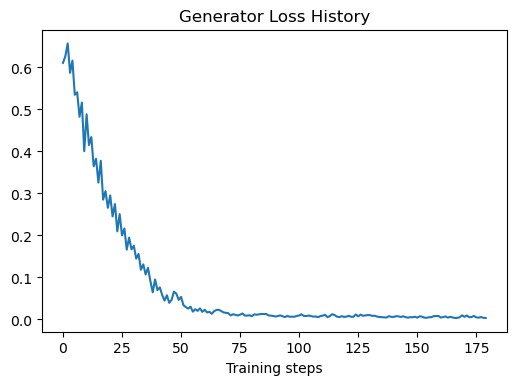

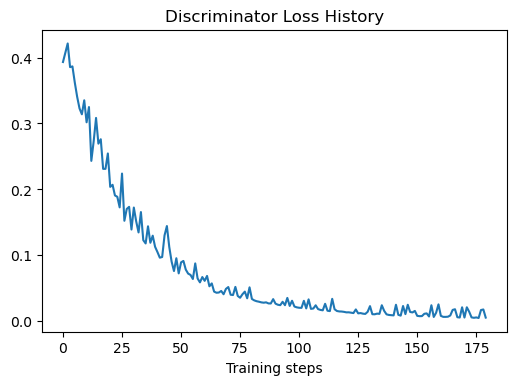

In [140]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

In [141]:
a_exam = generate_sequences(1000, G, BATCH_SIZE, T)

In [142]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
b_exam = generate_sequences(1000, G0,BATCH_SIZE, T)

In [143]:
a_exam

[[[1.0],
  [5.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [2.0],
  [4.0],
  [4.0],
  [5.0],
  [4.0],
  [4.0],
  [5.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [1.0],
  [5.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [5.0],
  [3.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.

In [144]:
b_exam

[[[1.0],
  [4.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [2.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [3.0],
  [2.0],
  [4.0],
  [3.0],
  [2.0],
  [3.0],
  [5.0],
  [5.0],
  [4.0],
  [4.0],
  [2.0],
  [2.0],
  [4.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0]],
 [[1.0],
  [3.0],
  [3.0],
  [5.0],
  [5.0],
  [3.

In [145]:
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/seqgan_original'
if not os.path.exists(model_save_dir + '/G_run_1'):
    os.makedirs(model_save_dir + '/G_run_1')

G_save_path = model_save_dir + '/G_run_1/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_1'):
    os.makedirs(model_save_dir + '/D_run_1')

D_save_path = model_save_dir + '/D_run_1/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Debug

### Debug the D of seq-gan

In [ ]:
def build_D_1(T, event_vocab_dim, emb_dim, num_filters=100, kernel_size=4, dropout_rate=0.25):
    # Highway network
    i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type

    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_et = mask_layer(i_et)
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    embed0 = tf.squeeze(embed0, axis=2)

    conv1 = Conv1D(
        filters=num_filters,
        kernel_size=kernel_size,
        strides=1,
        padding="valid",
        activation='relu',
        use_bias=True,
        kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
        bias_initializer=tf.keras.initializers.Constant(value=0.1))(embed0)
    
    pooled = MaxPooling1D(pool_size=T-kernel_size+1, strides=1)(conv1)
    
#     highwayed = highway_layers(pooled, n_layers=1, activation="relu", gate_bias=0)

#     dropped = Dropout(rate=dropout_rate)(highwayed)
    
    prob = Dense(1, 
                 activation='sigmoid',
                 name='final',
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
                 bias_initializer=tf.keras.initializers.Constant(value=0.1))(pooled)

    discriminator = Model(
        inputs=i_et,
        outputs=prob)

    return discriminator

In [ ]:
def build_D_2(T, event_vocab_dim, emb_dim, num_filters=100, kernel_size=4, dropout_rate=0.25):    
    # normal LSTM
    i_et = Input(batch_shape=(BATCH_SIZE, T, 1), name='event_type')  # input of discrete feature event type
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    
    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
    embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(HIDDEN_DIM, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)
              
    dropped = Dropout(rate=dropout_rate)(hm)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)  

    discriminator = Model(
        inputs=i_et,
        outputs=prob)

    return discriminator

In [ ]:
pretrain_D_et = np.concatenate([neg_event_type_seqs[0:1000], pos_event_type_seqs[0:1000]], axis=0)
pretrain_D_labels = np.concatenate([np.zeros((1000, 1)), np.ones((1000, 1))], axis=0)

In [ ]:
EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * 2000 / BATCH_SIZE)

pretrain_D_dataset = create_dataset(pretrain_D_et,
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=2000) # shuffle the entire Dataset

pretrain_disc_token_loss_history = []

In [ ]:
D1 = build_D_1(T=T,
             event_vocab_dim=EVENT_VOCAB_DIM,
             emb_dim=32,
             num_filters=1000,
             kernel_size=8,
             dropout_rate=0.1)

D1.summary()

In [ ]:
D2 = build_D_2(T=T,
             event_vocab_dim=EVENT_VOCAB_DIM,
             emb_dim=32,
             num_filters=100,
             kernel_size=4,
             dropout_rate=0.1)

D2.summary()

In [ ]:
step = 0
OPTIMIZER = Adam(lr=1e-4)
for event_type_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, labels, D1, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())